My goal in this notebook is to train an image classifier model to tie together what I've learned in the first two units of the course.fast.ai deep learning course. 

I recently watched Season 2, Episode 5 of The Rehearsal, which features an emotion recognition test where you guess a person's emotion based only on their eyes (not the contents of their full face). The test is called Reading the Mind in the Eyes (RMET), and more information is available here: https://embrace-autism.com/reading-the-mind-in-the-eyes-test/.

I'd ultimately like to build a model that could pass this test, however there are some complexities and data availability issues I'm not quite sure how to solve for yet. The main one is that there are many different emotions in the RMET test that don't have associated labeled training data. 

For this notebook, I'm setting a more modest goal, which is to train an emotion recognition model. It will predict the emotion depicted as one of eight categories: neutral, happy, angry, sad, fear, surprise, disgust, contempt (since that's what's in the dataset I'm using). However, I'm going to train the model only on the eyes, not on the full contents of the face. This will require some programmatic data curation.

In [139]:
# hide
import fastbook
fastbook.setup_book()

In [140]:
# hide
from fastbook import *
from fastai.vision.widgets import *

## Gathering Data

The first challenge is gathering data. I downloaded a dataset from HuggingFace here: https://huggingface.co/datasets/chitradrishti/AffectNet/tree/main. This has over 30K images across each of the 8 emotions (each emotion has over 2500 images). 

First, unzip the zip file containing all the images.

In [4]:
# only do this once (doesn't work in Jupyter notebook, has to be done from the shell)

# sudo apt-get install unzip
# unzip affectnet.zip -d ~/affectnet/

This has all the data (over 30K images). I'd rather just get the gist of the exercise for now and keep feedback cycles fast, so I'm going to pare this down to just 100 (update: 200) images per emotion. 

In [99]:
%%bash

mkdir -p ~/fastbook/02_training_data/
for dir in ~/affectnet/*/
do 
  d=$(basename "$dir")
  mkdir -p "02_training_data/$d"
  find "$dir" -maxdepth 1 -type f \( -name "*.jpg" -o -name "*.png" \) | head -200 | xargs -I {} cp {} "02_training_data/$d/"
done


The next quirk I noticed was different emotions had different file types. For example, all the anger images were saved as .jpgs, and all the contempt images were saved as .pngs. I assume modern deep learning libraries handle this, but it would be good to test that converting a png to jpg, for example, doesn't change the final model's predictions.

Next, let's validate the data, using some of the code from the book

In [247]:
path_with_faces = Path('/home/paperspace/fastbook/02_training_data')
fns = get_image_files(path_with_faces)
fns

(#1600) [Path('/home/paperspace/fastbook/02_training_data/sad/image0028342.jpg'),Path('/home/paperspace/fastbook/02_training_data/sad/image0027171.jpg'),Path('/home/paperspace/fastbook/02_training_data/sad/image0024545.jpg'),Path('/home/paperspace/fastbook/02_training_data/sad/image0023466.jpg'),Path('/home/paperspace/fastbook/02_training_data/sad/image0030161.jpg'),Path('/home/paperspace/fastbook/02_training_data/sad/image0029666.jpg'),Path('/home/paperspace/fastbook/02_training_data/sad/image0021802.jpg'),Path('/home/paperspace/fastbook/02_training_data/sad/image0002684.jpg'),Path('/home/paperspace/fastbook/02_training_data/sad/image0022910.jpg'),Path('/home/paperspace/fastbook/02_training_data/sad/image0013521.jpg'),Path('/home/paperspace/fastbook/02_training_data/sad/image0025843.jpg'),Path('/home/paperspace/fastbook/02_training_data/sad/image0006642.jpg'),Path('/home/paperspace/fastbook/02_training_data/sad/image0023099.jpg'),Path('/home/paperspace/fastbook/02_training_data/sad/im

In [248]:
failed = verify_images(fns)
failed

(#0) []

## Load Data

First, let's load the data in with no cropping (full face) to get a feel for how the data looks.

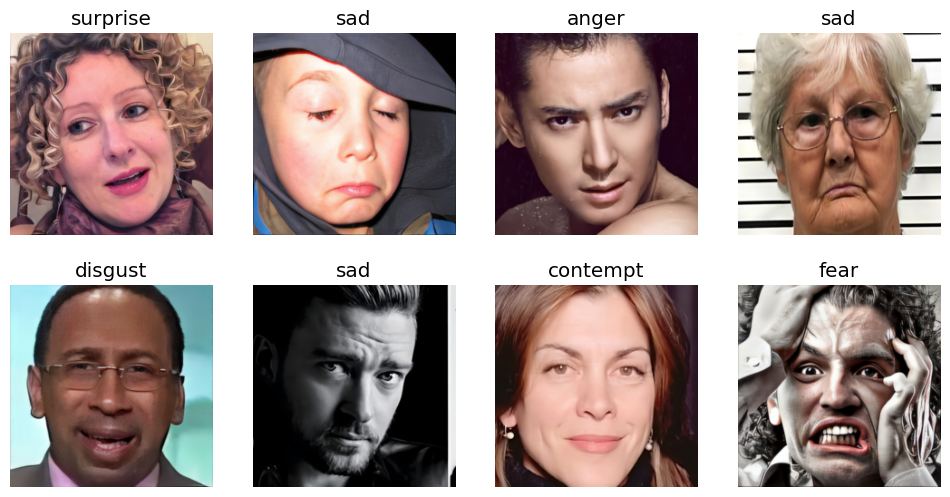

In [249]:
faces = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224))

dls_faces = faces.dataloaders(path1)

dls_faces.valid.show_batch(max_n=8, nrows=2)

It looks like the eyes are consistently located in the middle 20% of the image. Let's try cropping each image around the middle to see if it does a reasonable job of only isolating the eyes.

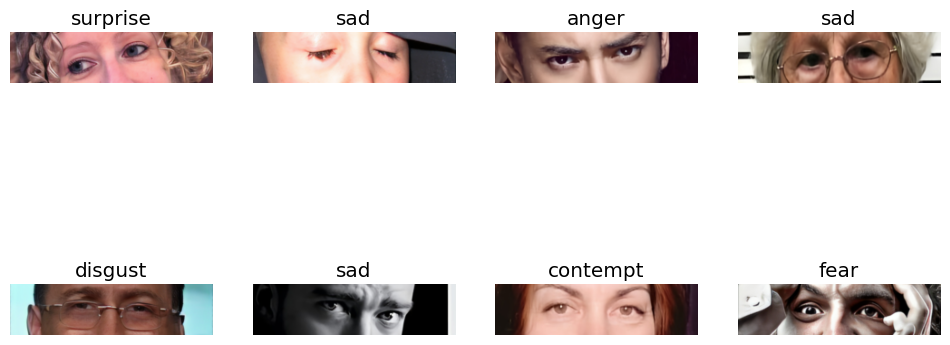

In [250]:
class ResizeAndCropEyes(Transform):
    def __init__(self, size=224, top_pct=0.30, bottom_pct=0.55):
        self.size = size
        self.top_pct = top_pct
        self.bottom_pct = bottom_pct
    
    def encodes(self, img: PILImage):
        """Resize then crop to eye region"""
        # First resize
        img = img.resize((self.size, self.size), Image.BILINEAR)
        
        # Then crop
        w, h = img.size
        top = int(h * self.top_pct)
        bottom = int(h * self.bottom_pct)
        
        return PILImage.create(img.crop((0, top, w, bottom)))

eyes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=ResizeAndCropEyes(224)
) 

dls_eyes = eyes.dataloaders(path1)

dls_eyes.valid.show_batch(max_n=8, nrows=2)

### Save the Cropped Data

Let's first save the cropped data to disk using only the transform, then we'll use another data loader that reads the cropped data to disk, resizes, and uses that to train the model.

First step: save the cropped data to disk.

In [251]:
path_with_eyes = Path('/home/paperspace/fastbook/02_training_data_cropped')
path_with_eyes.mkdir(exist_ok=True)

crop_transform = ResizeAndCropEyes(224)

for img_path in progress_bar(get_image_files(path_with_faces)):
    img = PILImage.create(img_path)
    cropped = crop_transform(img)
    relative_path = img_path.relative_to(path_with_faces)
    new_path = path_with_eyes/relative_path
    new_path.parent.mkdir(parents=True, exist_ok=True)
    cropped.save(new_path)

Next step, create a data loader off of that data. This will be used to train the model.

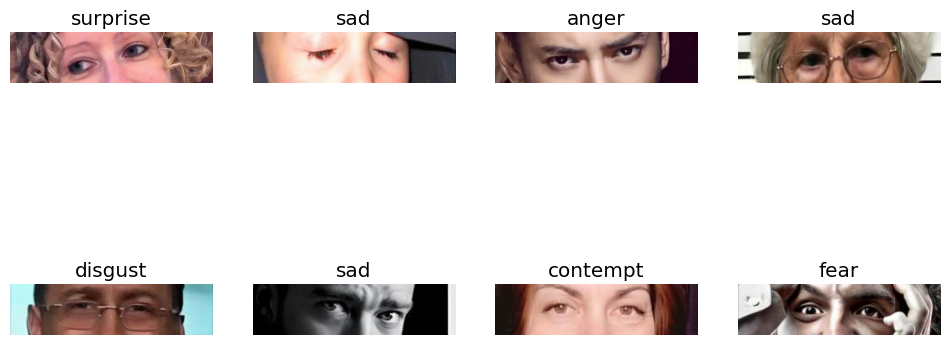

In [252]:
class ResizeExact(Transform):
    def __init__(self, width, height):
        self.width = int(width)
        self.height = int(height)
    
    def encodes(self, img: PILImage):
        return PILImage.create(img.resize((self.width, self.height), Image.BILINEAR))

eyes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=ResizeExact(224, 224*0.25),  # still use resizing for consistency at inference-time
    batch_tfms=aug_transforms()
) 

dls = eyes.dataloaders(path_with_eyes)

dls.valid.show_batch(max_n=8, nrows=2)

## Train a Model

Next, let's train a model and see how it does, and see where the big losses are (as in the book). 

In [253]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.143636,2.125614,0.740625,00:21


epoch,train_loss,valid_loss,error_rate,time
0,2.395341,1.876313,0.675000,00:32
1,2.207718,1.925658,0.665625,00:31
2,1.978173,1.841540,0.646875,00:32
3,1.825533,1.814921,0.640625,00:32


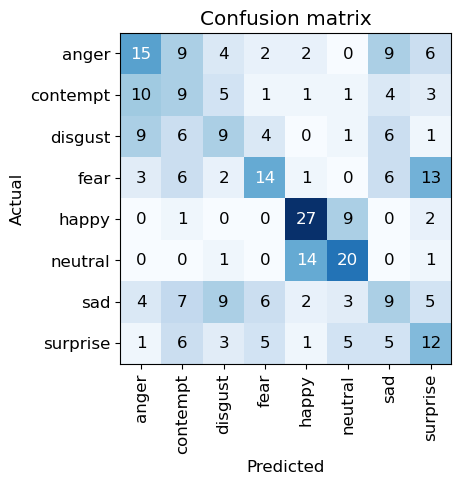

In [254]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

A lot of these seem reasonable:
- mixing up happy and neutral
- mixing up fear and surprise
- mixing up anger/disgust and sadness 

But let's see if there's any issues with the data itself

Performance:
- first run (0.35 - 0.525 height):	                2.08 validation loss / 0.69 error rate
- second run (0.30 - 0.55 height + aug_transforms): 2.20 validation loss / 0.65 error rate
- third run (above + 200 images per category instead of 100): 1.86 validation loss / 0.65 error rate

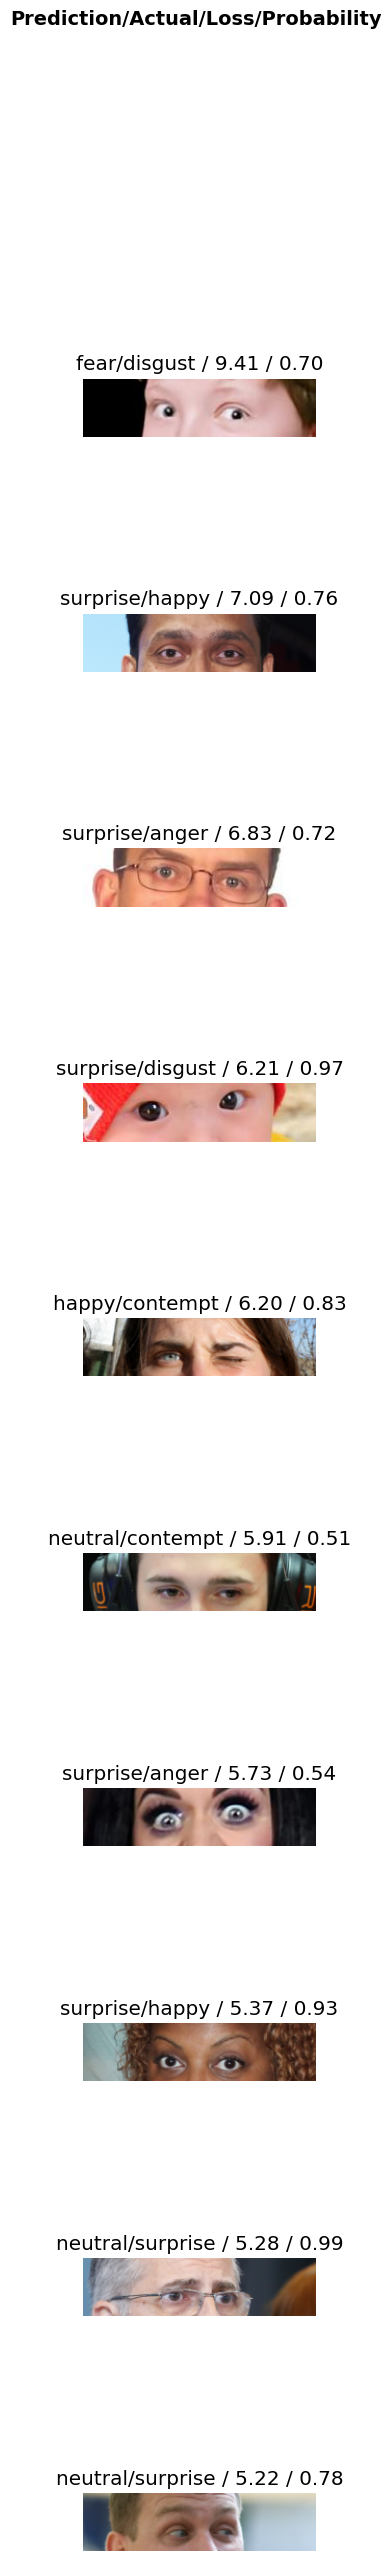

In [255]:
interp.plot_top_losses(10, nrows=10)

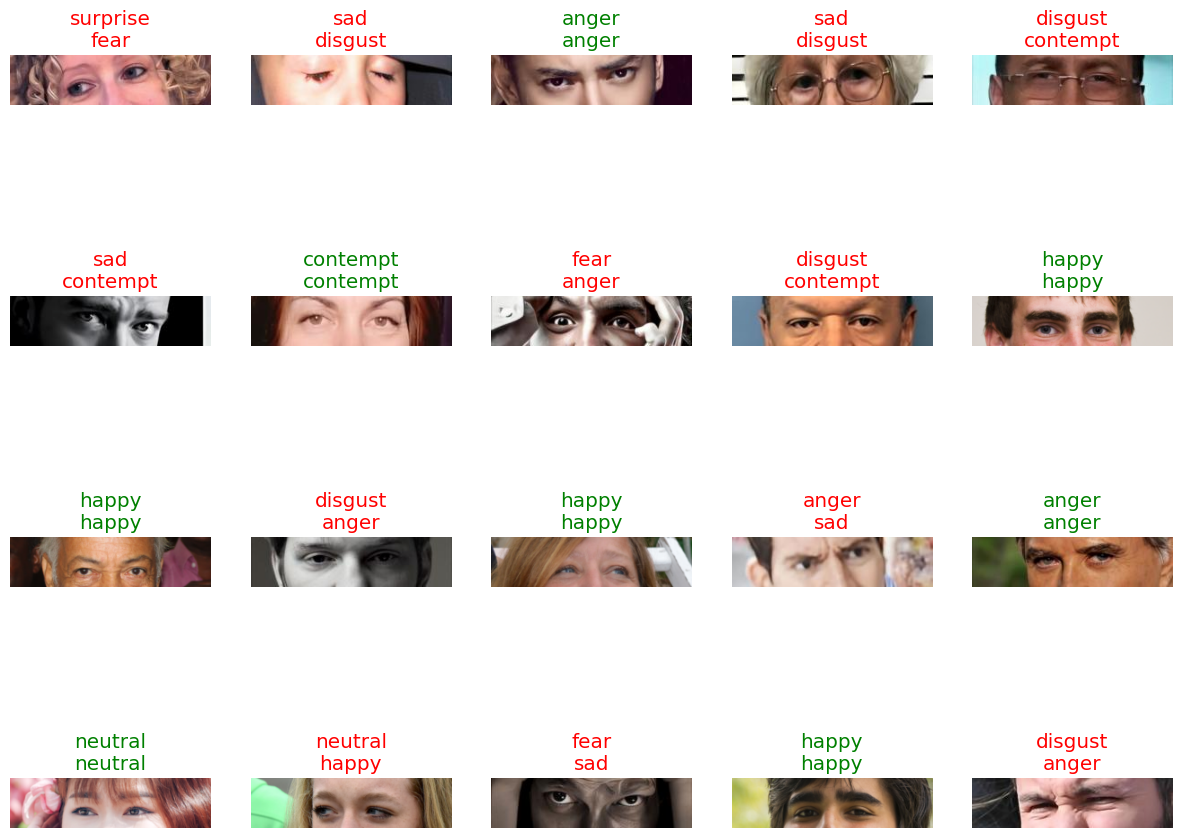

In [256]:
interp.show_results(list(range(0, 20)))

All of these are actually pretty reasonable crops of the eyes, however, they differ from the RMET test in that some of these don't show eyebrows, and all the images on the RMET test do. Going to try the crop again by cropping to 30% of the way down the image, rather than 35, and extend from 0.525 to 0.55. Also, I will put in aug_transforms.

In [257]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

## Validate Loaded Learner

In [258]:
!sha1sum export.pkl

8388f7858fcd0e81dfd932e69a66ce53417581f1  export.pkl


In [259]:
learn = load_learner('export.pkl')

/home/paperspace/miniforge3/lib/python3.12/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [269]:
idx = 18  # idx from the `interp.show_results(...)` line above

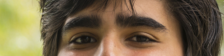

In [270]:
item = interp.dl.items[idx]  # same items 
img = PILImage.create(item)
img

In [271]:
learn.predict(item)

('happy',
 tensor(4),
 tensor([1.4662e-04, 1.5779e-03, 3.2140e-04, 2.5790e-05, 5.7976e-01, 4.1795e-01, 2.3013e-05, 1.9470e-04]))